# Week 1

### A brief (not exhaustive) introduction to financial data

In quantitative finance, the core object we work with is a **time series of prices** for each asset.  
For equities, these prices are typically provided as **OHLCV** data, where each daily record contains:

- **Open** — first traded price of the day  
- **High** — highest price reached  
- **Low** — lowest price reached  
- **Close** — final traded price  
- **Volume** — number of shares traded  
- **Adjusted Close** — close price corrected for dividends and splits (used for return calculations)

Daily OHLCV values are **aggregated summaries**, not individual trades.

> A *tick* represents a single trade or quote update. Daily OHLCV bars aggregate many ticks into one daily observation.

For most modeling tasks involving equities, the **Adjusted Close** is the primary field of interest. It incorporates corporate actions, ensuring that any quantities derived from it—returns, volatility, correlations—are consistent over time.

#### Returns

Given prices $ P_t $, we define **returns** as the relative change in price from one time step to the next.  
In this project, we will primarily work with **log returns**. They are known for their useful statistical properties.
$$
r_t = \log(P_t) - \log(P_{t-1}).
$$
Log returns are additive across time, behave well numerically, and are standard in both academic research and industry practice.  
For a detailed explanation, see [Why Log Returns?](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

#### Features from rolling windows

Once returns are available, we can compute **features** that summarize recent price behavior.  
These are based on **rolling windows**, meaning that at time $ t $, we only use data from the past $W$ days.  
This avoids lookahead bias and aligns with how real trading systems operate.

#### Common rolling features

1. **Rolling Returns (e.g., 5-day or 20-day return)** Measures short-term price movement:
   $$
   \text{ret}_{t}^{(W)} = \frac{P_t}{P_{t-W}} - 1.
   $$
   Useful for capturing recent upward or downward trends.

2. **Rolling Volatility (e.g., 20-day standard deviation of returns)** Quantifies the recent variability or risk:
   $$
   \sigma_t^{(W)} = \sqrt{\frac{1}{W-1} \sum_{k=0}^{W-1} (r_{t-k} - \bar{r}_t)^2 }.
   $$
   Volatility is a central input to portfolio optimization.

3. **Momentum (rolling mean of recent returns)** Captures persistent directional movement.  
   Momentum is one of the strongest empirical signals in quantitative finance.

4. **Rolling Correlations and Covariance** Describe how assets move together, and are essential for diversification and portfolio variance calculations.

#### Quantifying Risk

Risk is the uncertainty of returns. In portfolio optimization, we quantify it to ensure we aren't taking on excessive danger for a given level of reward. While **Volatility** (Standard Deviation) is the most common metric, it treats upside jumps (good) and downside drops (bad) equally.

Alternative methods allow us to focus specifically on the risk of loss:

1.  **Downside Deviation:** Similar to standard deviation, but calculates the spread using **only negative returns** (or returns below a target). This filters out "good volatility."
2.  **Maximum Drawdown (MDD):** Measures the largest percentage drop from a cumulative peak to a subsequent trough over a specific period. It answers: "What is the worst loss an investor could have suffered?"
3.  **Value at Risk (VaR):** A probabilistic metric that estimates the maximum expected loss over a set horizon at a given confidence level (e.g., "We are 95% confident the daily loss won't exceed 2%").

Here, we'll mostly focus on simple covariance (volatility) based risk models, but the readers are encouraged to explore other models on their own. This is further discussed in the last section.

--- 

#### Prerequisites (Light but Helpful)

**Linear Algebra**
A few core ideas are useful:
- vectors and matrices, basic operations
- the least-squares idea behind linear regression

**Statistics**
You should be comfortable with:
- mean, variance, covariance  
- interpreting returns as random variables
- common distributions (gaussian, log normal, uniform)
- standard results based on iid assumptions

Resources are mentioned below.

---

### References
- Any standard linear algebra and statistics refresher intended for data science should suffice.
  - You may look at: [CS215 Fall 2025](https://www.cse.iitb.ac.in/~ajitvr/CS215_Fall2025/)
  - See MIT OCW link below
- **Analysis of Financial Time Series, Tsay (2010)**
  - Ch 1, 2 state important statistical facts about financial data series.
  - A summary of important stats concepts is included
- [Portfolio Optimization Book](https://portfoliooptimizationbook.com/)
  - Ch 1, 2 may be relevant (optional)

Additional resources:
- **MIT OCW 18.S096 (Topics in Mathematics with Applications in Finance)**
  - The [Fall 2013 offering](https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/pages/lecture-notes/) has lecture notes as well. The Fall 2024 offering is also up on the website.
- [PyportfolioOpt cookbook](https://github.com/PyPortfolio/PyPortfolioOpt/blob/main/cookbook/)
---

### 1. Reading financial data
`yfinance` is a Python module that exposes financial data from Yahoo's APIs (see Yahoo! Finance) for personal use.

- [Official documentation](https://ranaroussi.github.io/yfinance/)
- [Additional reference](https://algotrading101.com/learn/yfinance-guide/)

In [104]:
import yfinance as yf
import pandas as pd
import numpy as np


In [105]:
aapl = yf.Ticker("AAPL")  # define a single Ticker object - detailed info on one stock/fund - here the AAPL stock


In [106]:
aapl.info  # .info is used to gain a variety of useful informations, please explore it yourself


{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '(408) 996-1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple Vision Pro, Apple TV, Apple Watch, Beats products, and HomePod, as well as Apple branded and third-party accessories. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download app

In [107]:
# some data
some_fields = ['forwardPE', 'marketCap', 'volume', 'dividendRate']
for field in some_fields:
    print(f"AAPL {field} : {aapl.info[field]}")

print("Analyst price targets: ", aapl.analyst_price_targets)


AAPL forwardPE : 30.076895
AAPL marketCap : 4067898949632
AAPL volume : 49752479
AAPL dividendRate : 1.04
Analyst price targets:  {'current': 274.11, 'high': 350.0, 'low': 215.0, 'mean': 286.57584, 'median': 300.0}


In [108]:
# history method - see ref: https://ranaroussi.github.io/yfinance/reference/yfinance.price_history.html
aapl.history(period='1mo', interval='1d').head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-11-17 00:00:00-05:00,268.820007,270.489990,265.730011,267.459991,45018300,0.0,0.0
2025-11-18 00:00:00-05:00,269.989990,270.709991,265.320007,267.440002,45677300,0.0,0.0
2025-11-19 00:00:00-05:00,265.529999,272.209991,265.500000,268.559998,40424500,0.0,0.0
2025-11-20 00:00:00-05:00,270.829987,275.429993,265.920013,266.250000,45823600,0.0,0.0
2025-11-21 00:00:00-05:00,265.950012,273.329987,265.670013,271.489990,59030800,0.0,0.0


In [109]:
# yf.download is used to download time series data for multiple stocks for given time frame
# see https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html

# set auto_adjust=False to get the 'Adj Close' 

tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]
data = yf.download(tickers, start="2017-01-01", end="2020-01-01", auto_adjust=False)
data['Adj Close'].head()


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,MSFT,TLT
Date,,,,,
2017-01-03,26.770885,37.683498,39.014385,56.299313,93.882286
2017-01-04,26.740917,37.859001,39.052109,56.047409,94.243240
2017-01-05,26.876905,39.022499,39.405453,56.047409,95.718483
2017-01-06,27.176542,39.799500,40.007439,56.533203,94.839615
2017-01-09,27.425461,39.846001,40.032253,56.353291,95.600822


In [110]:
# the columns are multi-level
# extracting individual stock data can be done using pandas methods

data.xs('MSFT', axis=1, level=1)


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2017-01-03,56.299313,62.580002,62.840000,62.130001,62.790001,20694100
2017-01-04,56.047409,62.299999,62.750000,62.119999,62.480000,21340000
2017-01-05,56.047409,62.299999,62.660000,62.029999,62.189999,24876000
2017-01-06,56.533203,62.840000,63.150002,62.040001,62.299999,19922900
2017-01-09,56.353291,62.639999,63.080002,62.540001,62.759998,20382700
...,...,...,...,...,...,...
2019-12-24,149.429367,157.380005,157.710007,157.119995,157.479996,8989200
2019-12-26,150.654190,158.669998,158.729996,157.399994,157.559998,14520600
2019-12-27,150.929550,158.960007,159.550003,158.220001,159.449997,18412800


### 2. Feature extraction with 🐼
Manipulating tick data (ticker history) to extract features.

In [111]:
# we only work with Adj Close for most of our features
# NOTE: for missing days we fill in data by "filling forward" P_t-1 -> P_t and then "filling backward"

# Note the value of T (no of ticks) and N (no of assets) = 2

prices = data['Adj Close'].ffill().bfill()
prices


Ticker,AAPL,AMZN,GOOG,MSFT,TLT
Date,,,,,
2017-01-03,26.770885,37.683498,39.014385,56.299313,93.882286
2017-01-04,26.740917,37.859001,39.052109,56.047409,94.243240
2017-01-05,26.876905,39.022499,39.405453,56.047409,95.718483
2017-01-06,27.176542,39.799500,40.007439,56.533203,94.839615
2017-01-09,27.425461,39.846001,40.032253,56.353291,95.600822
...,...,...,...,...,...
2019-12-24,68.588493,89.460503,66.677895,149.429367,115.749207
2019-12-26,69.949310,93.438499,67.513626,150.654190,116.028328
2019-12-27,69.922783,93.489998,67.091301,150.929550,116.155182


In [112]:
# extracting features
logret= np.log(prices).diff().dropna()  # (T-1, N) # dropna to drop the first row
roll_mean = logret.rolling(20).mean().dropna()  # (T-21, N)
roll_vol = logret.rolling(20).std().dropna()  # rolling 20 day volatility
roll_cov = logret.rolling(20).cov().dropna()  # rolling 20 day covariance
cum_ret = np.exp(logret.cumsum()) - 1  # cumulative returns


### 3. Visualization

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# some global stylistic settings
plt.style.use("seaborn-v0_8-talk")
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"] = 0.8

# choose an asset to visualize
asset = 'MSFT'


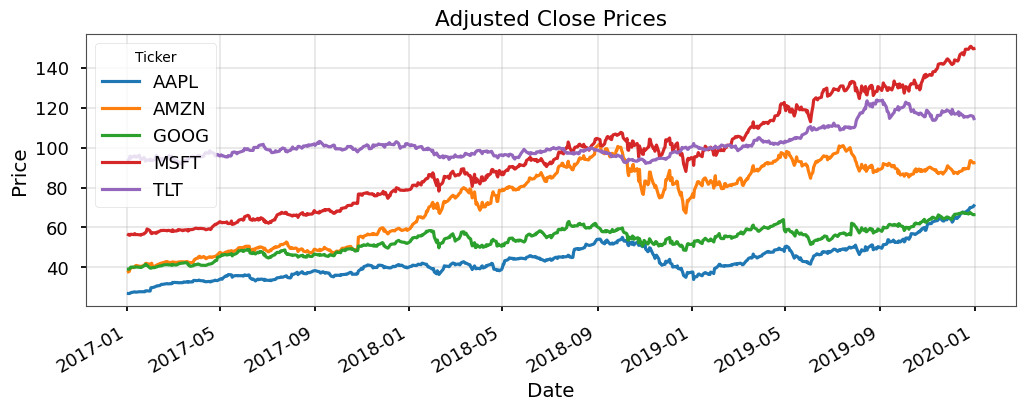

In [114]:
# ticker df can be plotted directly
prices.plot(title="Adjusted Close Prices")
plt.ylabel("Price")
plt.show()


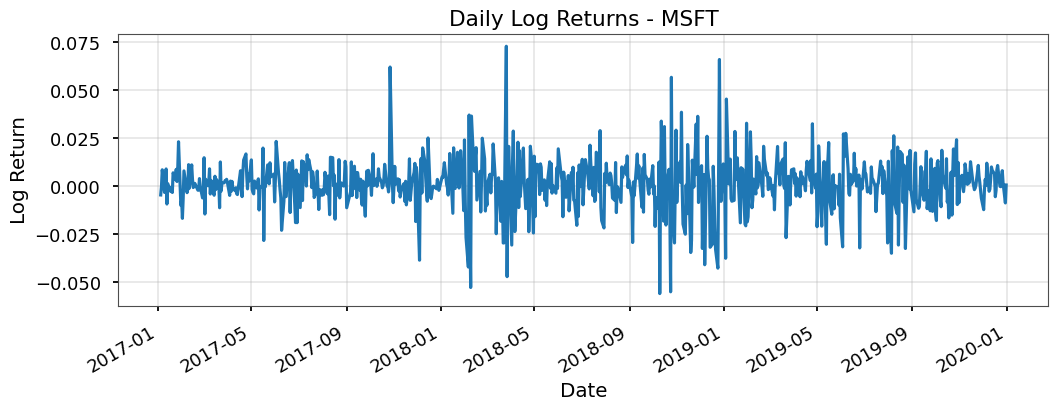

In [115]:
logret[asset].plot(title=f"Daily Log Returns - {asset}")
plt.ylabel("Log Return")
plt.show()


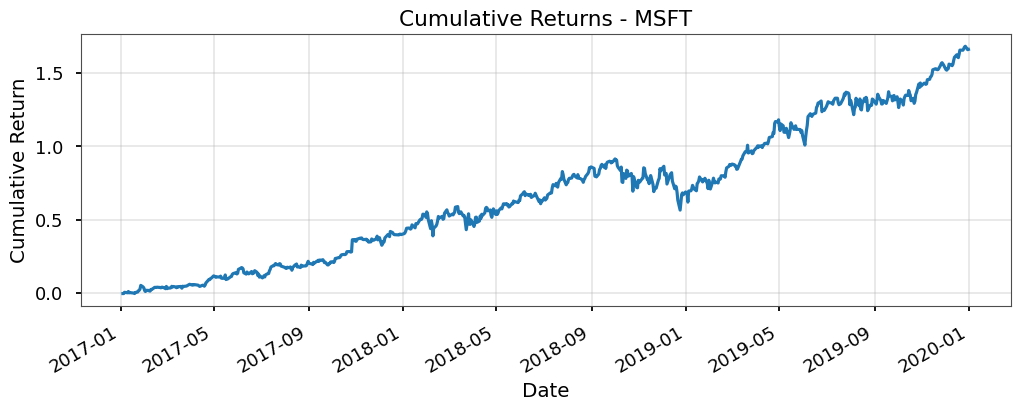

In [116]:
cum_ret[asset].plot(title=f"Cumulative Returns - {asset}")
plt.ylabel("Cumulative Return")
plt.show()


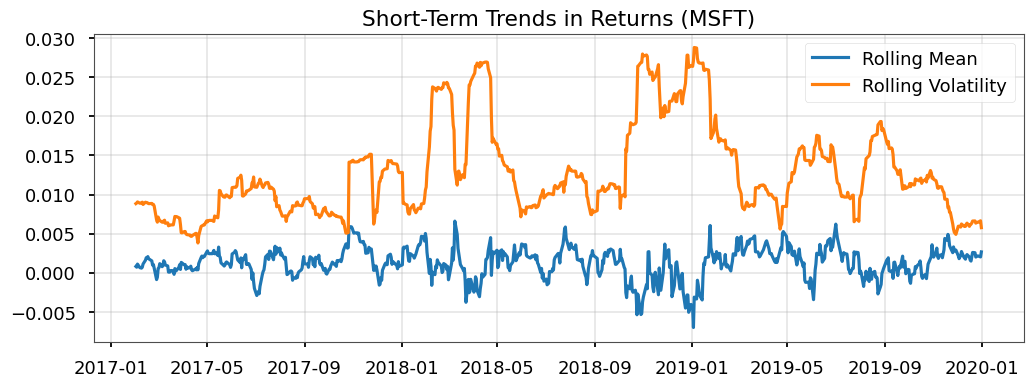

In [117]:
plt.plot(roll_mean[asset], label=f"Rolling Mean")
plt.plot(roll_vol[asset], label=f"Rolling Volatility")
plt.title(f"Short-Term Trends in Returns ({asset})")
plt.legend()
plt.show()


### 4. Statistical modelling
Financial data is *famoously non-gaussian* with heavy tails, and asymmetry (skewness, kurtosis etc.). We'll visualize these.

See the book (and slides) for more info.

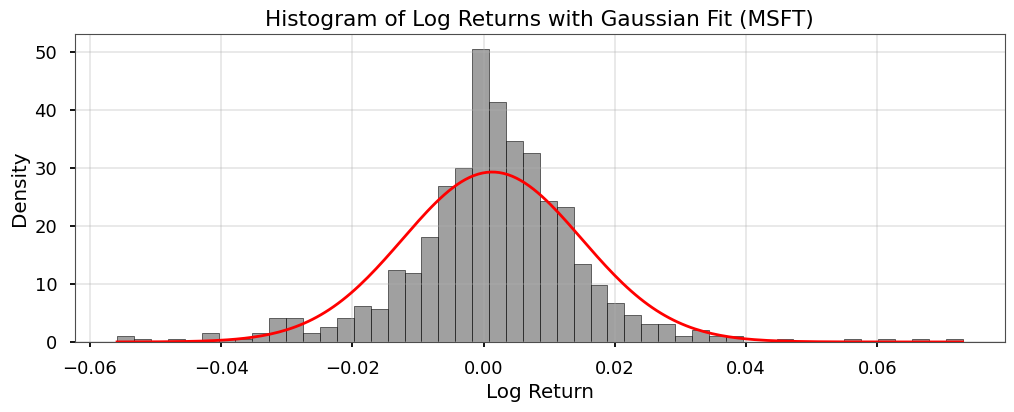

Mu = 0.001, Sigma = 0.014


In [118]:
import scipy.stats as st

asset_data = logret[asset].dropna()

# set up histogram for log return
plt.figure()
sns.histplot(asset_data, bins=50, kde=False, stat="density", color="grey")

# fit a normal distribution on log returns
mu, sigma = asset_data.mean(), asset_data.std()
x = np.linspace(asset_data.min(), asset_data.max(), 200)
plt.plot(x, st.norm.pdf(x, mu, sigma), 'r', lw=2)

plt.title(f"Histogram of Log Returns with Gaussian Fit ({asset})")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.show()

# also print
print(f"Mu = {mu:.3f}, Sigma = {sigma:.3f}")


In [119]:
print("Skew:", st.skew(asset_data))  # != 0 indicates asymmetry
print("Kurtosis (excess):", st.kurtosis(asset_data))  # > 0 indicates fat tails

# optional, see how these change as you vary the time window from 3 mo, 1 yr, 5 yr


Skew: -0.03782745785111195
Kurtosis (excess): 3.786055683037742


### 5. Misc topics
1. Random Walk Hypothesis
2. Data cleaning - Filling in missing rows
3. ACF and PACF plots
4. Toy Portfolio Construction
5. Efficient Frontier

These topics will be covered in detail later. Here we provide some motivation for them (the code here is mostly ornamental).

#### Random Walks
One of the important tasks in financial modelling is to model asset returns. We use asset returns because of their "nicer" statistical properties as compared to raw price values. Formally the goal is to derive:
$$
f(r_T, r_{T-1}, \dots, r_1 ; \theta), \quad\text{where }\theta\text{ refers to parameters controlling the market prices}
$$

This can be written as:
$$
f(r_T, r_{T-1}, \dots, r_1) = f(r_1) f(r_2 \mid r_1) f(r_3 \mid r_2, r_1) ... f(r_T \mid r_{T-1}, \dots r_1)
$$

This highlights the strong temporal dependence in asset returns. We make a simplifying assumption that returns at any time are *independent* of past returns. Hence, they allow us to describe $r_t, t \in \{1,\dots,T\}$ using the marginal distribution only. This forms the basis for the *random walk hypothesis*.

> Model log returns as normally distributed and (temporally) independent. Then cumulative returns become the result of a random walk - cumulative sum of i.i.d. normal variables.

Text(0.5, 1.0, 'Synthetic Random Walk')

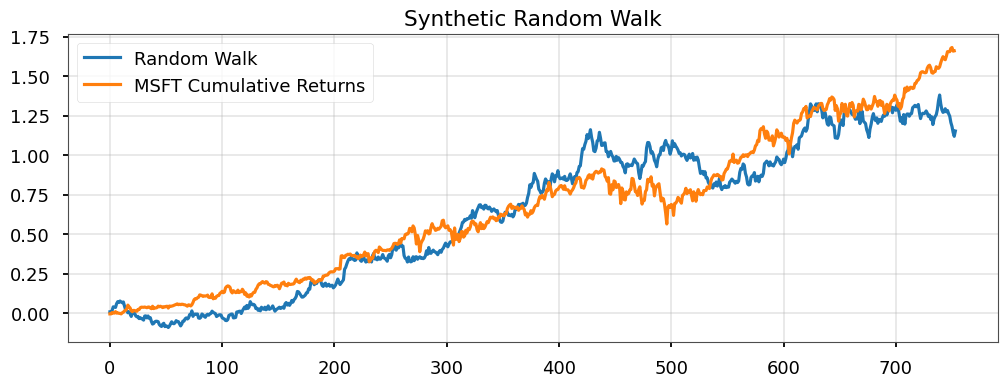

In [120]:
# uncomment this to make it nondeterministic
np.random.seed(42)

rand_walk = np.exp(np.cumsum(np.random.normal(mu, sigma, size=len(prices)))) - 1  # using mu, sigma from above asset
plt.plot(rand_walk, label='Random Walk')
plt.plot(np.array(cum_ret[asset]), label=f'{asset} Cumulative Returns')
plt.legend()
plt.title("Synthetic Random Walk")


#### Handling missing data

In [121]:
# we should be more careful with our data - check for missing values, nan etc.
# we already saw .ffill, .bfill and .dropna to deal with NaN entries
# we see how to spot entire missing rows

full_range = pd.date_range(prices.index.min(), prices.index.max(), freq="B")
missing = full_range.difference(prices.index)
missing


DatetimeIndex(['2017-01-16', '2017-02-20', '2017-04-14', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-11-23', '2017-12-25',
               '2018-01-01', '2018-01-15', '2018-02-19', '2018-03-30',
               '2018-05-28', '2018-07-04', '2018-09-03', '2018-11-22',
               '2018-12-05', '2018-12-25', '2019-01-01', '2019-01-21',
               '2019-02-18', '2019-04-19', '2019-05-27', '2019-07-04',
               '2019-09-02', '2019-11-28', '2019-12-25'],
              dtype='datetime64[ns]', freq=None)

In [122]:
# fixing it: reindexing
prices_full = prices.reindex(full_range).ffill().bfill()

# now run the above code blocks after running this line
prices = prices_full


#### ACF and PACF metrics (see [here](https://portfoliooptimizationbook.com/slides/slides-stylized-facts.pdf))

To understand time dependence, we use two key metrics:

* **ACF (Autocorrelation Function):** Measures the correlation between the series at time $t$ and time $t-k$. It captures the "total" correlation, including both the direct relationship and the indirect influence carried over by all intermediate time steps.
* **PACF (Partial Autocorrelation Function):** Measures the correlation between time $t$ and $t-k$ while **removing** the effects of the intervening lags. It isolates the strict, direct relationship between those two specific points in time.

These slides mention ACF and PACF metrics to analyze time dependence (or lack thereof) in returns and volatility/absolute returns.

**Key results:**
* $\sim0$ autocorr in returns but *significant* autocorr in volatility/absolute returns.
* This indicates that modelling returns using traditional linear models is **hard**. This, in part, motivates this project - the use of ML-based techniques to derive better models for predicting returns.
* On the other hand, it points towards the concept of *volatility clustering*, hinting that modelling volatility using autoregression based models is easier.

The `statsmodels` library exposes functions for ACF and PACF computation. Find more info here - https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

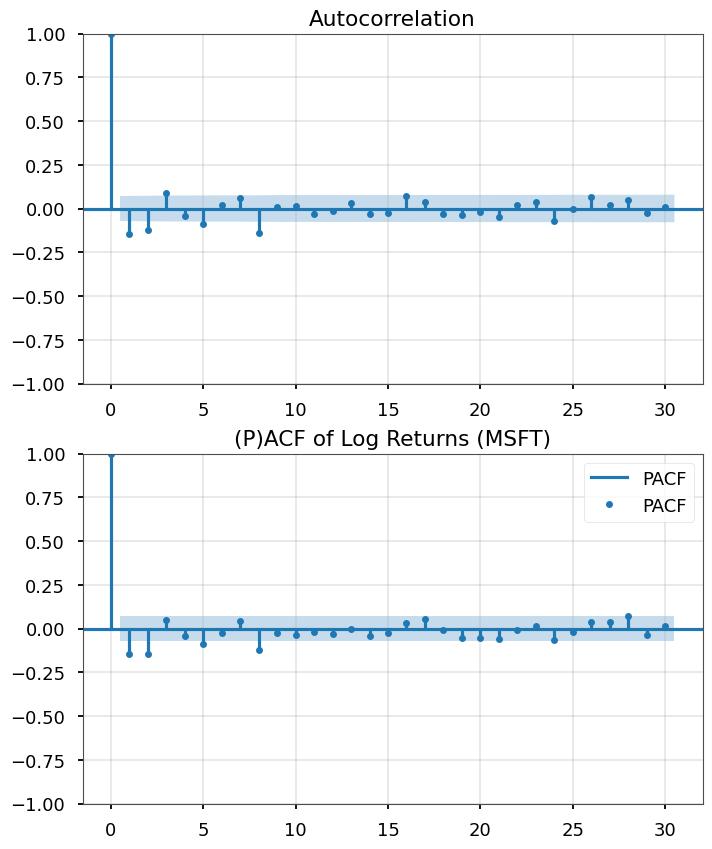

In [123]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(8,10))
plot_acf(asset_data, ax[0], lags=30, label='ACF')
plot_pacf(asset_data, ax[1], lags=30, method='ywm', label='PACF')
plt.title(f"(P)ACF of Log Returns ({asset})")
plt.legend()


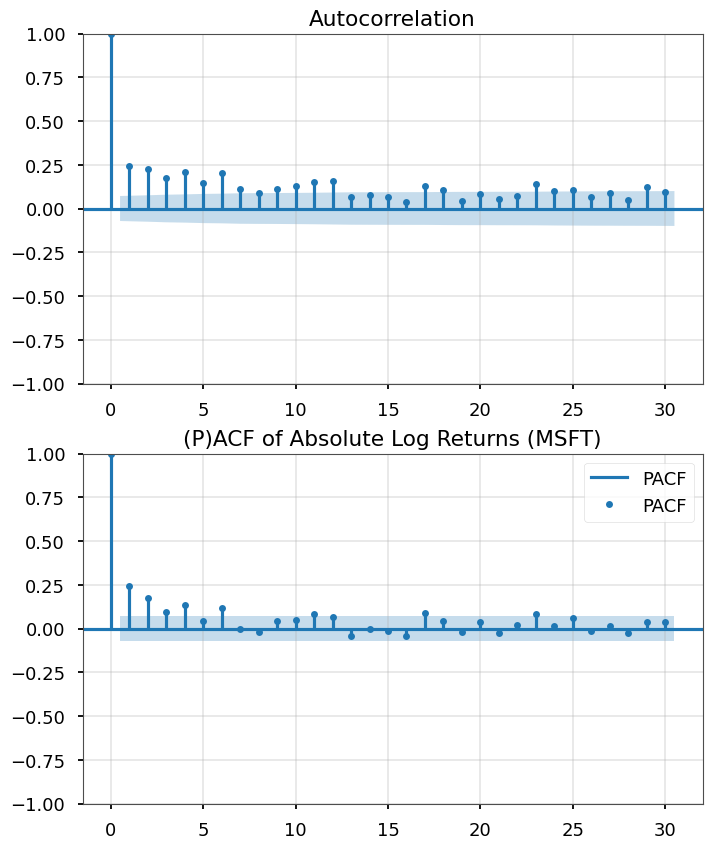

In [124]:
asset_data_abs = np.abs(asset_data)

fig, ax = plt.subplots(2, 1, figsize=(8,10))
plot_acf(asset_data_abs, ax[0], lags=30, label='ACF')
plot_pacf(asset_data_abs, ax[1], lags=30, method='ywm', label='PACF')
plt.title(f"(P)ACF of Absolute Log Returns ({asset})")
plt.legend()


#### Toy portfolio construction + Efficient Frontier

Put simply, a portfolio is a distribution of assets among a number of different instruments (typically stocks/equities), with the goal of reducing overall risk while ensuring higher net returns.

We can treat our portfolio rigorously as a vector of weights $\mathbf{w} \in \mathbb{R}^N$ where $\sum_i w_i = 1$. A larger value indicates a larger share of the total investment value. Non-negative values indicate a long position (buying the stock) and negative ones indicate short positions (selling the stock).

**1. Analyzing Risk and Correlation**
Remember, the goal is to minimize risk. Risk is the unexpected variation in returns.
The portfolio return is a simple weighted average: $R_p = \mathbf{w}^T \mathbf{R}$.
However, the portfolio **risk** (variance) is **not** a linear weighted average. It is determined by the covariance matrix $\Sigma$:

$$
\sigma_p^2 = \mathbf{w}^T \Sigma \mathbf{w} = \sum_{i} w_i^2 \sigma_i^2 + \sum_{i \neq j} w_i w_j \sigma_i \sigma_j \rho_{ij}
$$

**Key Insight:** The second term depends on the correlation coefficient $\rho_{ij}$.
* If $\rho_{ij} < 1$, the portfolio risk is strictly less than the weighted average of individual risks.
* If $\rho_{ij} < 0$ (negative correlation), the variance is significantly dampened. This is why we analyze the correlation matrix first—we want to combine assets that do *not* move together.

*Note: Estimating risk is a topic of high interest. There are many different methods of estimating true risk - sample covariance, exponentially weighted averages, Ledoit-Wolf shrinkage based estimates etc. - interested readers are encouraged to read about them.*

> **Technical Note: Log Returns vs. Simple Returns**
> * **Log Returns** ($r_t$) are additive across **time** ($\sum r_t$) but **not assets**.
> * **Simple Returns** ($R_t$) are additive across **assets** ($R_p = \sum w_i R_i$) but not time. We must use this for aggregating portfolio returns.
>
> **Implication:** We cannot simply dot product weights with log returns. We must convert log returns to simple returns (`np.exp(logret) - 1`), compute the weighted sum, and then convert back.


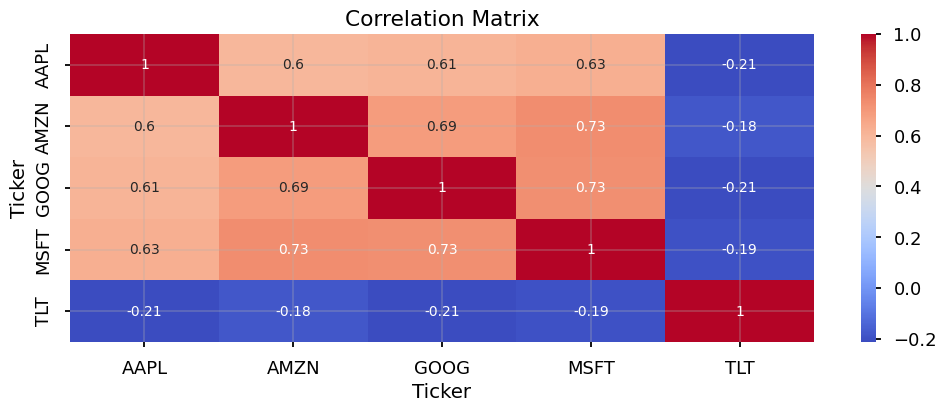

In [125]:
# 1. Analyze Correlation to inform weight selection
# We look for assets with low or negative correlation to the rest of the universe.
sns.heatmap(logret.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [126]:
# 2. Define Weights
# Strategy: TLT (Treasury Bonds) often has negative correlation with equities.
# We overweight TLT to dampen portfolio variance via the covariance term.
frac_TLT = 0.28
num_stocks = len(logret.columns) - 1  # Assuming TLT is one column
port_w = np.array([(1 - frac_TLT) / num_stocks] * num_stocks + [frac_TLT])
equal_w = np.ones(len(logret.columns)) / len(logret.columns)


In [127]:
# 3. Compute Portfolio Returns (Use simple returns for aggregation!)
simple_ret = np.exp(logret) - 1
port_simple = simple_ret.dot(port_w)
equal_simple = simple_ret.dot(equal_w)


In [128]:
# 4. Plot Cumulative Performance
(np.exp(updated_logret.cumsum()) - 1).plot()
plt.title("Cumulative Returns")
plt.show()


NameError: name 'updated_logret' is not defined

#### Visualizing efficient frontier

If we construct every possible portfolio from a set of assets (by varying $\mathbf{w}$), we generate a "cloud" of possible risk-return pairs called the **Feasible Set**.
* The **Efficient Frontier** is the upper boundary of this set.
* For any given level of risk (x-axis), the portfolio on the frontier offers the maximum possible return.
* Portfolios inside the curve are sub-optimal (same risk, less return).

We can use `PyPortfolioOpt` to mathematically solve the exact curve using the Critical Line Algorithm (CLA). This gives us a smooth, continuous EfficientFrontier.

We then overlay our manually constructed portfolios ("Equal" and "Port") to see how close we got to the theoretical optimum.

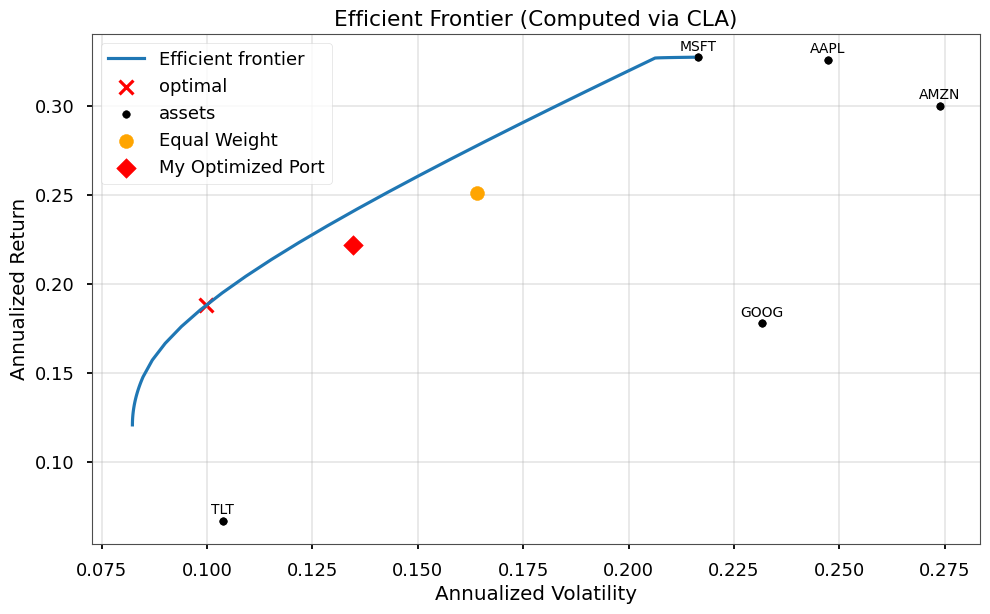

In [ ]:
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting, CLA

# PyPortfolioOpt needs expected returns (mu) and covariance matrix (S)
assets_only = logret.drop(columns=['Port', 'Equal'], errors='ignore')
mu = assets_only.mean() * 252
S = assets_only.cov() * 252

# Compute the Efficient Frontier using CLA
cla = CLA(mu, S)
cla.max_sharpe()

port_stats = updated_logret.agg(['mean', 'std']).T
port_stats['mean'] *= 252
port_stats['std'] *= np.sqrt(252)

# Plotting
plt.figure(figsize=(10, 6))

plotting.plot_efficient_frontier(cla, show_assets=True)

# Overlay Our Custom Portfolios
plt.scatter(port_stats.loc['Equal', 'std'], port_stats.loc['Equal', 'mean'], 
            color='orange', s=100, marker='o', label='Equal Weight', zorder=10)
plt.scatter(port_stats.loc['Port', 'std'], port_stats.loc['Port', 'mean'], 
            color='red', s=100, marker='D', label='My Optimized Port', zorder=10)

for asset_ in logret.columns:
    plt.scatter(port_stats.loc[asset_, 'std'], port_stats.loc[asset_, 'mean'], 
            color='black', s=100, marker='.', zorder=10)
    plt.annotate( asset_,  (port_stats.loc[asset_, 'std'], port_stats.loc[asset_, 'mean']),
        textcoords="offset points", xytext=(0, 5), ha='center')
    

plt.title("Efficient Frontier (Computed via CLA)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.show()
